# Decision tree


#### Import and clean data 

In [1]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, accuracy_score

from matplotlib.pyplot import figure
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from IPython.display import display
from data_processing import prepare_data, split_data
from helper_functions import get_metrics

In [75]:
# Clean the data
# Do not normalize the data as we need non-normalized data to be able to interpret it
data = prepare_data('healthcare-dataset-stroke-data.csv', normalize = False)

# Split the data into training, testing and validation data
train_data, test_data, val_data, train_labels, test_labels, val_labels = split_data(data, split_size=(0.6, 0.2, 0.2))

### Basic model

In [89]:
def train_and_predict(model, training_data, training_labels, testing_data):
    """
    This function trains an instance of the model based on input training data and training labels. 
    It returns the predicted labels for the training_data and the testing_data in a tuple.
    """
    # Fit the data to the model
    model.fit(training_data, training_labels)
    
    # Predict labels for training and testing data
    train_predict = model.predict(training_data)
    test_predict = model.predict(testing_data)
    
    # Return predictions over the training (to test model accuracy for learned data) and testing data
    return train_predict, test_predict

# Make an instance of the DecisionTreeClassifier with a fixed random state
tree = DecisionTreeClassifier(min_samples_split = 2, max_depth = 500, random_state = 0)

# Get the predictions
prediction_train, prediction_test = train_and_predict(tree, train_data, train_labels, test_data)

# Print the accuracies
print("For the training data:")
train_acc, train_balacc = get_metrics(train_labels, prediction_train, verbose = True)

print("For the testing data")
test_acc, testbalacc = get_metrics(test_labels, prediction_test, verbose = True)

For the training data:
accuracy: 100.0000 % 

balanced accuracy: 100.0000 %
sensitivity: 1.0000
specificity: 1.0000 

confusion matrix: 
[[2916    0]
 [   0  149]] 

[["True Negative", "False Positive"] 
 ["False Negative", "True Positive"]] 

For the testing data
accuracy: 92.5636 % 

balanced accuracy: 58.1481 %
sensitivity: 0.2000
specificity: 0.9630 

confusion matrix: 
[[936  36]
 [ 40  10]] 

[["True Negative", "False Positive"] 
 ["False Negative", "True Positive"]] 



### Parameter optimization options
There are multiple ways to optimize a decision tree. We will look at:
1. Early stopping &rarr; where to stop
2. Pruning &rarr; cutting leafs

#### Option 1: Early stopping

Make sure the tree is less deep, by using a minimum number of samples that must be present to split the leaf or by giving a maximum tree depth to the algoritm. First we try to find the best minimum number of samples. 

In [6]:
def plot_accuracy(x, training_acc, val_acc, title, x_lab, y_lab = 'accuracy'):
    """
    Plot a list of values, x, and plots a list of training (training_acc) and validation accuracies (val_acc). List should be
    the same length. X-labels and titles should be given; there is the option of setting a custom y-label as the option of 
    setting a different title.
    """
    # Plot validation and training accuracy in same plot
    plt.plot(x, training_acc, 'b')
    plt.plot(x, val_acc, 'r')
    
    # Give x and y labels and title
    plt.xlabel(x_lab)
    plt.ylabel(y_lab)
    plt.title(title)
    
    # Label the lines for training and validation accuracy
    plt.legend(['train accuracy', 'validation accuracy'])
    
    # Set an ylim so accuracy is always shown from 0 to 1
    plt.ylim([0, 1.1])
    
    plt.show()

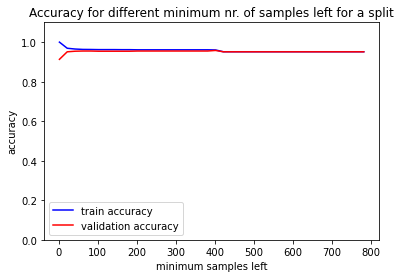

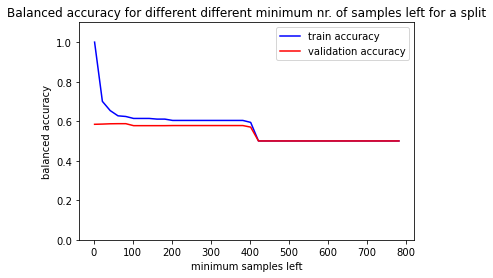

best split size: 62
highest validation accuracy: 0.5874279835390946


In [94]:
def try_upgrade(x_min, x_max, x_step, data, titles, x_label, model = DecisionTreeClassifier, upgrade = "min_samples_split"):
    ''' 
    This function tries different values (x) for model parameters (upgrade) and plot the accuracies for the different values. 
    It returns the x value that had maximum balanced accuracy on the testing data.
    The minimum and maximum values and step size for the various values for x should be given by x_min, x_max and x_step.
    Data is tuple with both training data and labels and testing/validation data and labels
    Titles is a list with first the title for the plot that plots accuracy, and second the title of the plot with balanced 
    accuracy.
    Model is what type of classifier is used; it can be DecisionTreeClassifier (default) or RandomForestClassifier
    Upgrade should be a parameter of the model given as a string, for example "min_samples_split" for the DecisionTree
    '''
    
    # Unpack data
    training_data, training_labels, vali_data, vali_labels = data
    
    # Create a range for different values for the model parameter
    x = np.arange(x_min, x_max, x_step)

    # The accuracy for the various values for the model parameter will be appended to these lists
    training_accuracy = []
    vali_accuracy = []
    training_accuracy_balanced = []
    vali_accuracy_balanced = []

    # Loop over all parameter values
    for value in x:
            
        # Make a dictionary out of the parameter we upgrade and the value we use in this split
        dictionary = {upgrade: value}
        
        if upgrade == 'class_weight':
            
            dictionary = {upgrade: {0:1, 1:value}}
                
        # Unpack the values for the model parameter from the dictionary and set these as model parameters for out model
        tree = model(**dictionary, random_state = 12)
        
        # Use the train_and_predict function to fit data to the model and predict the labels using the model
        training_predict, vali_predict = train_and_predict(tree, training_data, training_labels, vali_data)

        # Get accuracy for training and validation data
        train_acc, train_bal_acc = get_metrics(train_labels, training_predict)
        val_acc, val_bal_acc = get_metrics(vali_labels, vali_predict)

        # Append the accuracies to the lists
        training_accuracy.append(train_acc)
        training_accuracy_balanced.append(train_bal_acc)
        vali_accuracy.append(val_acc)
        vali_accuracy_balanced.append(val_bal_acc)
    
    # Plot the findings
    plot_accuracy(x, training_accuracy, vali_accuracy, titles[0], x_label)
    plot_accuracy(x, training_accuracy_balanced, vali_accuracy_balanced, 
                  titles[1], x_label, 'balanced accuracy')
    
   
    # Find the best value that has the maximum balanced validation accuracy
    index_max = np.argmax(vali_accuracy_balanced)
    best_x = x[index_max]
    high_val = vali_accuracy_balanced[index_max]
    
    return best_x, high_val

# Data we will be giving to this function
data_model = (train_data, train_labels, val_data, val_labels)

# Titles for the plots
titles = ["Accuracy for different minimum nr. of samples left for a split", 
          "Balanced accuracy for different different minimum nr. of samples left for a split"]

# Set the range for the split size between 2 and 700, as we have a large dataset
best_split, validation = try_upgrade(2, 800, 20, data_model, titles, 'minimum samples left', upgrade = 'min_samples_split')

print(f'best split size: {best_split}')
print(f'highest validation accuracy: {validation}')


This shows that 2 is the best split size for the balanced accuracy for the validation data, which is a bit odd as this is basically where the model is still overfitting quite a lot. There's also a dip in accuracy around 400 samples per split, as this probably limits the depth of the tree immensely.

Then we look for the best tree depth.

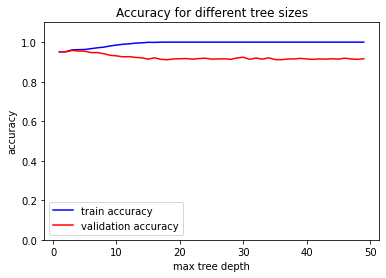

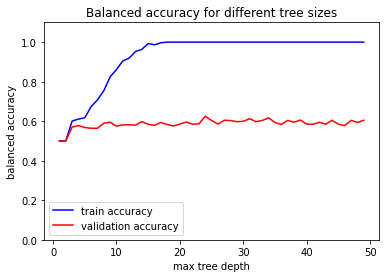

best tree size: 24
highest validation accuracy: 0.6253086419753087


In [45]:
# Titles for best tree depth
titles = ['Accuracy for different tree sizes', 'Balanced accuracy for different tree sizes']

best_depth, validation_size = try_upgrade(1, 50, 1, data_model, titles, 'max tree depth', upgrade = 'max_depth')
print(f'best tree size: {best_depth}')
print(f'highest validation accuracy: {validation_size}')

In [46]:
print(f'To maximize the tree depth it is best to give a min_split_size of {best_split} or a max_depth of ' 
      f'{best_depth} to the decision tree')

To maximize the tree depth it is best to give a min_split_size of 2 or a max_depth of 24 to the decision tree


Normally, it is not necessary to give both optimized values to a decision tree, because this will create a tree with too little depth, since both parameters are restrictions for the tree depth. However, our minimum split size is 2, which does not limit the tree depth at all, so we could try to apply both and see the accuracies of these values on the testing data:

In [47]:
# Use optimal values for the tree
tree = DecisionTreeClassifier(min_samples_split = best_split, max_depth = best_depth)

# Get the predictions
prediction_train, prediction_test = train_and_predict(tree, train_data, train_labels, test_data)

# Print the accuracies
print("For the training data:")
train_acc, train_balacc = get_metrics(train_labels, prediction_train, verbose = True)

print("For the testing data")
test_acc, testbalacc = get_metrics(test_labels, prediction_test, verbose = True)

For the training data:
accuracy: 100.0000 % 

balanced accuracy: 100.0000 %
sensitivity: 1.0000
specificity: 1.0000 

confusion matrix: 
[[2916    0]
 [   0  149]] 

[["True Negative", "False Positive"] 
 ["False Negative", "True Positive"]] 

For the testing data
accuracy: 92.4658 % 

balanced accuracy: 58.0967 %
sensitivity: 0.2000
specificity: 0.9619 

confusion matrix: 
[[935  37]
 [ 40  10]] 

[["True Negative", "False Positive"] 
 ["False Negative", "True Positive"]] 



### Option 2: pruning

Number of nodes in the last tree is: 1 with ccp_alpha: 0.0068885992747864345


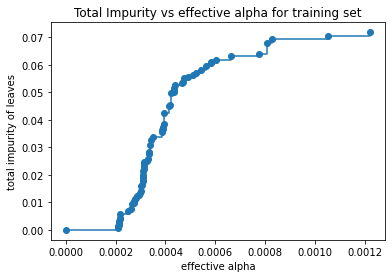

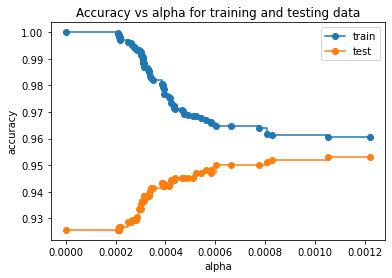

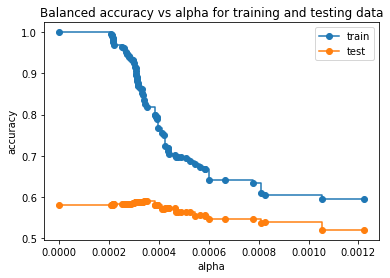

The best alpha is 0.0003415868067709742 leading to a balanced accuracy of 0.5897119341563786.The tree then has a depth of 17 and 165 nodes.
For the training data:
accuracy: 98.2708 % 

balanced accuracy: 82.5332 %
sensitivity: 0.6510
specificity: 0.9997 

confusion matrix: 
[[2915    1]
 [  52   97]] 

[["True Negative", "False Positive"] 
 ["False Negative", "True Positive"]] 

For the testing data
accuracy: 94.1292 % 

balanced accuracy: 58.9712 %
sensitivity: 0.2000
specificity: 0.9794 

confusion matrix: 
[[952  20]
 [ 40  10]] 

[["True Negative", "False Positive"] 
 ["False Negative", "True Positive"]] 



In [48]:
"""
Code from: https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html
"""

# Create a decision tree
tree = DecisionTreeClassifier(random_state=0)

# Compute the cost complexity parameter (ccp_alpha)
# Greater ccp_alpha means more nodes are pruned and impurities is information about how pure the nodes are
path = tree.cost_complexity_pruning_path(train_data, train_labels)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

# Plot the cost complexity parameter and the impurities for all trees but the one with only one node
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

# Create an empty list to save trees
trees = []

# Loop over all used cost complexity parameters 
for ccp_alpha in ccp_alphas:
    
    # Create a decision tree using this alpha
    tree = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    
    # Fit the tree on the data
    tree.fit(train_data, train_labels)
    
    # Add the tree to the list
    trees.append(tree)
    
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(trees[-1].tree_.node_count, ccp_alphas[-1]))

# Remove the tree without splits from the list with trees and the list with alpha's 
trees = trees[:-1]
ccp_alphas = ccp_alphas[:-1]

# Create empty list to save the normal accuracy and the balanced accuracy for both training and testing data
train_scores = []
test_scores = []
train_scores_balanced = []
test_scores_balanced = []

# Loop over all the trees
for tree in trees:
    
    # Get the predicted labels from the tree
    train_predict = tree.predict(train_data)
    test_predict = tree.predict(test_data)
    
    # Compute the accuracy and balanced accuracy
    train_accuracy, train_balanced = get_metrics(train_labels, train_predict)
    test_accuracy, test_balanced = get_metrics(test_labels, test_predict)
    
    # Add values to the correct list
    train_scores_balanced.append(train_balanced)
    train_scores.append(train_accuracy)
    test_scores_balanced.append(test_balanced)
    test_scores.append(test_accuracy)
    
# Plot the accuracies of the training and testing data with the cost complexity parameter
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing data")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

# Plot the balanced accuracies of the training and testing data with the cost complexity parameter
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Balanced accuracy vs alpha for training and testing data")
ax.plot(ccp_alphas, train_scores_balanced, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores_balanced, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

# Find the best alpha and tree by getting the maximum balanced validation accuracy
index_max = np.argmax(test_scores_balanced)
best_alpha = ccp_alphas[index_max]
high_balanced = test_scores_balanced[index_max]
best_tree = trees[index_max]

print(f'The best alpha is {best_alpha} leading to a balanced accuracy of {high_balanced}.'
      f'The tree then has a depth of {best_tree.tree_.max_depth} and {best_tree.tree_.node_count} nodes.')

# Get the predictions
prediction_train_pruned, prediction_test_pruned = train_and_predict(best_tree, train_data, train_labels, test_data)

# Print the accuracies
print("For the training data:")
train_accuracy, train_balaccuracy = get_metrics(train_labels, prediction_train_pruned, verbose = True)

print("For the testing data")
test_accuracy, test_balaccuracy = get_metrics(test_labels, prediction_test_pruned, verbose = True)

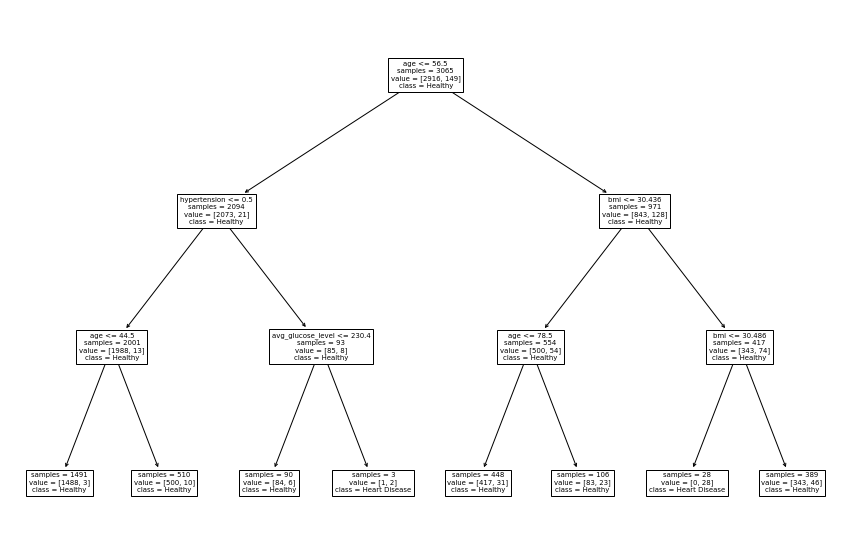

In [49]:
# Import this here because we use tree as a model name a few times as well 
from sklearn import tree

# Plot root of decision tree using this optimal split size, to see what this shows us about important features
d_tree = DecisionTreeClassifier(max_depth = 3, min_samples_split = best_split)
d_tree.fit(train_data, train_labels)

figure(figsize=(15, 10))
tree.plot_tree(d_tree, feature_names=data.columns.values, class_names=['Healthy', 'Heart Disease'], impurity=False);

# Random forest
Try a normal random forest, to see if many trees are better at predicting strokes as opposed to one tree. Try different ratios of training data that each tree in the forest in trained on.

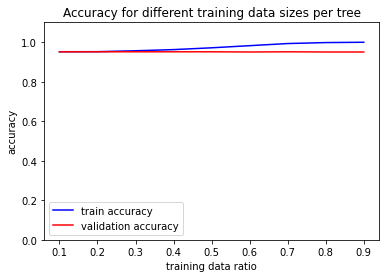

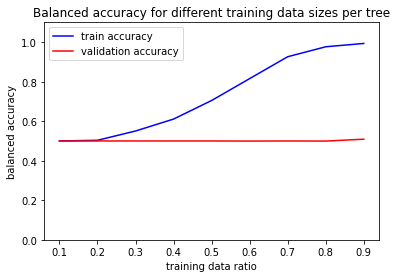

best training data ratio: 0.9
highest validation accuracy: 0.5089711934156378
For the training data:
accuracy: 99.9674 % 

balanced accuracy: 99.6644 %
sensitivity: 0.9933
specificity: 1.0000 

confusion matrix: 
[[2916    0]
 [   1  148]] 

[["True Negative", "False Positive"] 
 ["False Negative", "True Positive"]] 

For the testing data
accuracy: 95.3033 % 

balanced accuracy: 52.0000 %
sensitivity: 0.0400
specificity: 1.0000 

confusion matrix: 
[[972   0]
 [ 48   2]] 

[["True Negative", "False Positive"] 
 ["False Negative", "True Positive"]] 



In [74]:
from sklearn.ensemble import RandomForestClassifier

titles = ['Accuracy for different training data sizes per tree', 'Balanced accuracy for different training data sizes per tree' ]

# Get accuracies for the various amount of the data we train the model on
ratio, validation_acc = try_upgrade(0.1, 1, 0.1, data_model, titles, 'training data ratio', model = RandomForestClassifier,
                                    upgrade = 'max_samples')

print(f'best training data ratio: {ratio}')
print(f'highest validation accuracy: {validation_acc}')

# Get the accuracies on the testing data using the optimal ratio:
model = RandomForestClassifier(max_samples = ratio, class_weight = {0:1, 1:8}, max_features = None)
train_prediction, test_prediction = train_and_predict(model, train_data, train_labels, test_data)
# Print the accuracies
print("For the training data:")
train_acc, train_balacc = get_metrics(train_labels, train_prediction, verbose = True)

print("For the testing data")
test_acc, testbalacc = get_metrics(test_labels, test_prediction, verbose = True)


Normal random forests seems to work even worse than a single tree, as the random forest just classsifies everything as non-stroke. So we will try to train some trees using all the stroke data and only part of the total dataset; hopefully, this counteracts the imbalance between output classes in the dataset and makes it easier for the model to train.

In [108]:
def resampled_forest(data, nr_splits):
    """
    This function makes a forest of Classifiers, each trained on all of the data of patients with strokes and only part of the 
    sample of patients without strokes. The amount of trees is determined by nr_splits; this also determines how often
    the data is split. Data should be a tuple containing training data and labels, testing data and labels. Function returns
    the prediction of the forest for the training data and testing data, chosen by majority vote.
    """
    training_data, training_labels, testing_data, testing_labels = data
    
    # Seperate data from patients with stroke from no stroke by making a mask based on the labels 
    stroke_mask = train_labels == 1
    stroke_data = train_data[stroke_mask]

    # This selects the opposite of the mask, to get patients without stroke
    non_stroke_data = train_data[~stroke_mask]
    
    # Get variables to sum to later
    train_predicted = 0
    test_predicted = 0

    # Get the ratio that we will have to use for sampling the dataset for nr_splits amount of splits
    ratio = 1 / nr_splits

    # For the amount of splits, sample a new part of the data and train a new decision tree on it
    for split in range(nr_splits):

        # Get a sample of the non-stroke data
        sample_non_stroke = non_stroke_data.sample(frac = ratio)

        # Remove this sample from the dataset so we eventually use all the data to train our forest of trees
        non_stroke_data.drop(sample_non_stroke.index)

        # Append the non-stroke sample and our data for stroke patients to actually train the tree on
        mini_train = pd.concat((sample_non_stroke, stroke_data))

        # Get the labels belonging to this mini-train set
        mini_train_labels = training_labels[mini_train.index]

        # Make an instance of a DecisionTree
        model = DecisionTreeClassifier(ccp_alpha = 0.0003, class_weight = 'balanced')

        # Train our model on the mini-trainingset 
        model.fit(mini_train, mini_train_labels)

        # Predict labels for entire training data and testing data with this model
        train_predict = model.predict(training_data)
        test_predict = model.predict(testing_data)

        # Add the predicted scores for this model to the total scores over all trees
        train_predicted += train_predict
        test_predicted += test_predict

        # Calculate if the majority of the trees classified the training and testing sample as stroke or not
        train_predictions = train_predicted / nr_splits >= 0.5
        test_predictions = test_predicted / nr_splits >= 0.5

    #  Return the predictions
    return train_predictions, test_predictions 

For determining the optimal amount of datasplits, we will plot the accuracies for different number of datasplits.

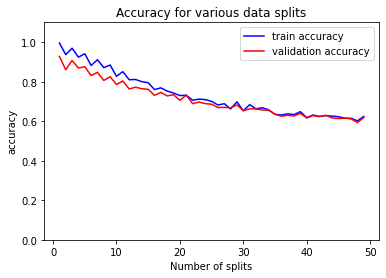

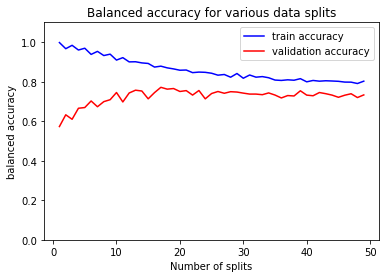

best split_size: 17
highest validation accuracy: 0.7713991769547326


In [109]:
# Get a range of splits between 1 and 50.
splits_range = np.arange(1, 50, 1)

# Create empty lists to save accuracies
training_accuracy = []
vali_accuracy = []
training_accuracy_balanced = []
vali_accuracy_balanced = []

# Loop over every split
for splits in splits_range:
    
    # Get the predictions for the training and validation data for this number of splits
    training_predictions, val_predictions = resampled_forest(data_model, splits)

    # Get accuracy for training and validation data
    train_acc, train_bal_acc = get_metrics(train_labels, training_predictions)
    val_acc, val_bal_acc = get_metrics(val_labels, val_predictions)

    # Append the accuracies to the lists
    training_accuracy.append(train_acc)
    training_accuracy_balanced.append(train_bal_acc)
    vali_accuracy.append(val_acc)
    vali_accuracy_balanced.append(val_bal_acc)

    
# Plot the findings with the plot_accuracy function
plot_accuracy(splits_range, training_accuracy, vali_accuracy, 'Accuracy for various data splits', 'Number of splits')
plot_accuracy(splits_range, training_accuracy_balanced, vali_accuracy_balanced, 
              'Balanced accuracy for various data splits', 'Number of splits', 'balanced accuracy')

# Find the best split by getting the maximum balanced validation accuracy
index_max = np.argmax(vali_accuracy_balanced)
best_split = splits_range[index_max]
high_val = vali_accuracy_balanced[index_max]


print(f'best split_size: {best_split}')
print(f'highest validation accuracy: {high_val}')

Let's see how well this split size does on the testing data.

In [110]:
data = train_data, train_labels, test_data, test_labels

# Train a forest with this best split
training_predictions, test_predictions = resampled_forest(data, best_split)

# Print the accuracies
get_metrics(train_labels, training_predictions, verbose = True);
get_metrics(test_labels, test_predictions, verbose = True);


accuracy: 77.1615 % 

balanced accuracy: 87.9973 %
sensitivity: 1.0000
specificity: 0.7599 

confusion matrix: 
[[2216  700]
 [   0  149]] 

[["True Negative", "False Positive"] 
 ["False Negative", "True Positive"]] 

accuracy: 74.0705 % 

balanced accuracy: 74.0370 %
sensitivity: 0.7400
specificity: 0.7407 

confusion matrix: 
[[720 252]
 [ 13  37]] 

[["True Negative", "False Positive"] 
 ["False Negative", "True Positive"]] 



The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y))

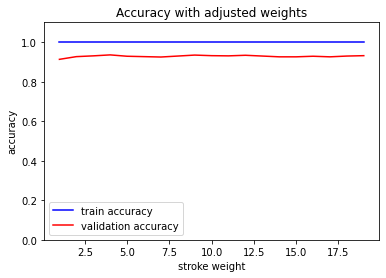

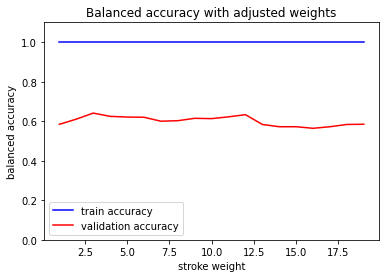

(3, 0.6409670781893004)

In [96]:
titles = ['Accuracy with adjusted weights', 'Balanced accuracy with adjusted weights']
try_upgrade(1, 20, 1, data_model, titles, 'stroke weight', model = DecisionTreeClassifier, upgrade = "class_weight")
